### Homework Assignment #4
#### Nicholas Kern
#### 9/30/16

In [1]:
from random import uniform
from numpy import logspace, array
from math import sqrt
from time import time,sleep
import multiprocessing as mult
import threading as thread
from ipyparallel import Client
from ipyparallel.util import interactive
from os import system
from Queue import Queue

In [2]:
def throw(N_darts,verbose=False):
    # Initialize
    N_darts = int(N_darts)
    hit = 0
    
    start = time()
    
    # Loop
    for n in range(N_darts):
        x,y = uniform(0,1), uniform(0,1)
        if sqrt((x-0.5)**2 + (y-0.5)**2) <= 0.5:
            hit += 1
    
    end = time()
    ellapsed = end-start
    rate = float(N_darts) / ellapsed
    
    pi_approx = 4 * float(hit) / N_darts
    
    if verbose == True:
        print "Pi Approx:", pi_approx
        print "N_darts:", N_darts
        print "Execution Time (s):",ellapsed
        print "Darts Thrown / Sec:", rate
    return ellapsed, rate

result = throw(1e4,verbose=True)

Pi Approx: 3.162
N_darts: 10000
Execution Time (s): 0.0486540794373
Darts Thrown / Sec: 205532.611359


In [3]:
dart_range = logspace(3,5,20)

In [7]:
# Naive direct evaluation
result_naive = array(map(throw,dart_range))

In [5]:
# Multiprocess with Pool
iterate = False
if iterate == True:
    result_pool = array([array(mult.Pool(4).map(throw,dart_range)) for i in range(10)]).T
else:
    result_pool = array(mult.Pool(4).map(throw,dart_range))

In [11]:
indices = array([[0,3,6,9],[1,4,7,10],[2,5,8,11]])
result = [[] for i in range(indices.size)]
print result

[[], [], [], [], [], [], [], [], [], [], [], []]


In [37]:
# Threading
class map_thread(object):
    def __init__(self,N_threads,thread_data,thread_data_indices):
        self.threads = []
        for i in range(N_threads):
            t = thread.Thread(target=self.worker,args=(thread_data,str(i)))
            self.threads.append(t)
            
        # Run
        self.start()
        
        # Get results
        self.collect_results(thread_data_indices)
    
    def worker(self,data,thread_id):
        # Brute Force for each thread
        result = array(map(throw,thread_data))
        self.__dict__['thread_'+thread_id+'_result'] = result
    
    def start(self):
        # Start threads
        for t in self.threads:
            t.start()
            
    def collect_results(self,indices):
        # Wait for finish
        for t in self.threads:
            t.join()
        
        # Compile results
        result = [[] for i in range(indices.size)]
        for i in range(len(indices)):
            for j in range(len(indices[i])):
                result[indices[i][j]] = self.__dict__['thread_'+str(i)+'_result'][j]
        
        return array(result)

In [25]:
def worker(num):
    """thread worker function"""
    print('Worker: %s' % num)
    sleep(10)
    return

threads = []
for i in range(5):
    t = thread.Thread(target=worker, args=(i,))
    threads.append(t)
    t.start()

Worker: 0
Worker: 1
Worker: 2
Worker: 3
Worker: 4


In [26]:
t.join()

In [3]:
# Outside of the notebook, you need to start engines
# Do this from a fresh terminal shell via "bash ipcluster_start.sh"

In [50]:
run throw_darts.py

In [51]:
# ipyparallel
c = Client()
view = c[:]

In [62]:
result_ipy = array(view.map(throw,dart_range).result())

In [5]:
# Plot
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as mp
import scipy.stats as stats

In [2]:
print "2010 MacBook Pro 2.4 GHz Intel Core 2 Duo"

2010 MacBook Pro 2.4 GHz Intel Core 2 Duo


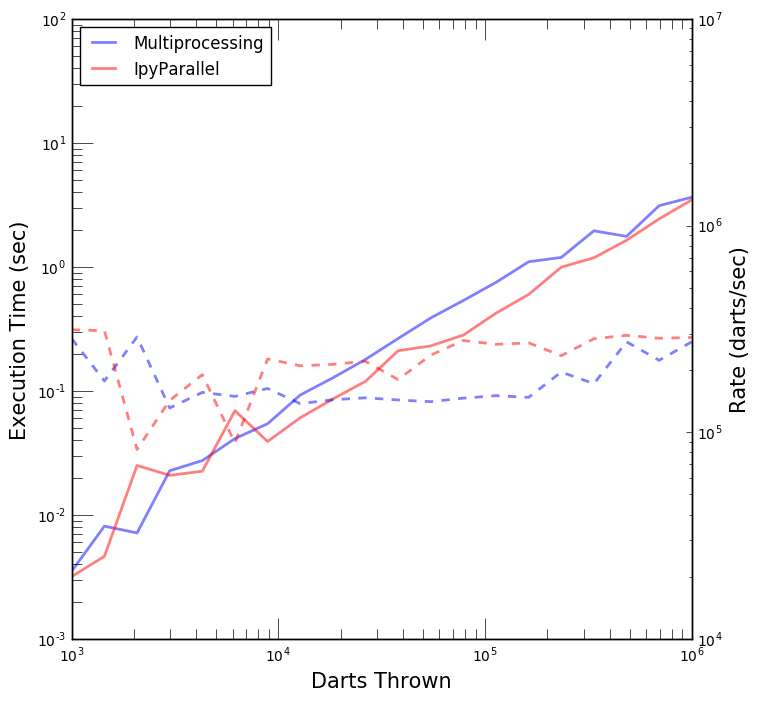

In [71]:
# Plot it!
fig = mp.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.tick_params(which='major',length=15)
ax1.tick_params(which='minor',length=7)
ax1.set_xlabel(r'Darts Thrown',fontsize=15)
ax1.set_ylabel(r'Execution Time (sec)',fontsize=15)
ax2.set_ylabel(r'Rate (darts/sec)',fontsize=15)
ax1.set_ylim(1e-3,1e2)
ax2.set_ylim(1e4,1e7)

p0, = ax1.plot(dart_range,result_pool.T[0],color='b',linewidth=2,alpha=0.5)
p1, = ax1.plot(dart_range,result_thread.T[0],color='g',linewidth=2,alpha=0.5)
p2, = ax1.plot(dart_range,result_ipy.T[0],color='r',linewidth=2,alpha=0.5)
p3, = ax1.plot(dart_range,result_naive.T[0],color='m',linewidth=2,alpha=0.5)

p4, = ax2.plot(dart_range,result_pool.T[1],color='b',linewidth=2,alpha=0.5,linestyle='--')
p5, = ax2.plot(dart_range,result_thread.T[1],color='g',linewidth=2,alpha=0.5,linestyle='--')
p6, = ax2.plot(dart_range,result_ipy.T[1],color='r',linewidth=2,alpha=0.5,linestyle='--')
p7, = ax2.plot(dart_range,result_naive.T[1],color='m',linewidth=2,alpha=0.5,linestyle='--')
ax1.legend([p0,p1,p2,p3],['Multiprocessing','Threading','IpyParallel','Naive Direct'],loc=2)